In [78]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# TODO : write a lidar file path, an img flie and calib file path
lidar_path = '/home/server-003/dl/mmdetection3d/data/superb/training/velodyne/000001.bin'
img_path = '/home/server-003/dl/mmdetection3d/data/superb/training/image_2/000001.jpg'
v2c_filepath = '/home/server-003/dl/mmdetection3d/data/superb/training/calib/000001.txt'
# lidar_path = '/home/server-003/dl/mmdetection3d/data/kitti/testing/velodyne/000000.bin'
# img_path = '/home/server-003/dl/mmdetection3d/data/kitti/testing/image_2/000000.png'
# v2c_filepath = '/home/server-003/dl/mmdetection3d/data/kitti/testing/calib/000000.txt'
# c2c_filepath = './calib_cam_to_cam.txt'
# TODO : mode means cam number , i.e) cam_00 's mode is 00
mode = '00'
v_fov = (-24.9, 2.0)
h_fov = (-45, 45)

In [88]:
h_fov[1:]

(45,)

In [89]:
# load lidar file(.bin)
def load_bin(bin_path):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points[:, :3]


velo_points = load_bin(lidar_path)
velo_points.shape

(230400, 3)

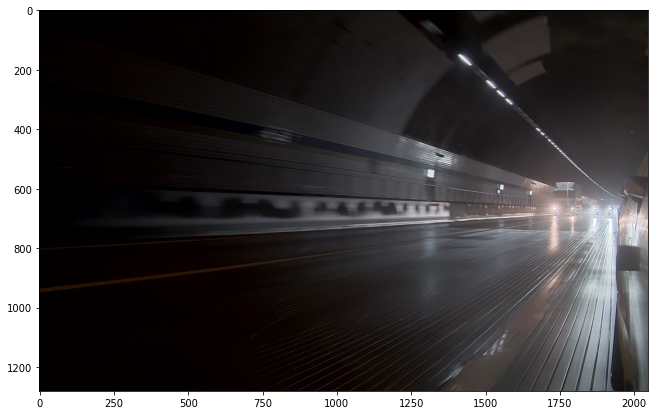

In [90]:
# load img file
image = cv2.imread(img_path)
height, width = image.shape[:2]
plt.subplots(1, 1, figsize=(15, 7))
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [91]:
def calib_velo2cam(filepath):
    """ 
    get Rotation(R : 3x3), Translation(T : 3x1) matrix info 
    using R,T matrix, we can convert velodyne coordinates to camera coordinates
    """
    with open(filepath, "r") as f:
        file = f.readlines()

        for line in file:
            try:
                (key, val) = line.split(':', 1)
                if key == 'Tr_velo_to_cam':
                    RT = np.fromstring(val, sep=' ')
                    RT = RT.reshape(3, 4)
    #             if key == 'T':
    #                 T = np.fromstring(val, sep=' ')
    #                 T = T.reshape(3, 1)
            except:
                print("excetp")
    return RT


def calib_cam2cam(filepath, mode):
    """
    If your image is 'rectified image' :
        get only Projection(P : 3x4) matrix is enough
    but if your image is 'distorted image'(not rectified image) :
        you need undistortion step using distortion coefficients(5 : D)

    in this code, I'll get P matrix since I'm using rectified image
    """
    with open(filepath, "r") as f:
        file = f.readlines()

        for line in file:
            try:
                (key, val) = line.split(':', 1)
                if key == 'P2':
                    P_ = np.fromstring(val, sep=' ')
                    P_ = P_.reshape(3, 4)
                    # erase 4th column ([0,0,0])
                    P_ = P_[:3, :3]
            except:
                print("except")
    return P_

In [92]:
# R_vc = Rotation matrix (lidar -> cam)# R_vc = Rotation matrix (lidar -> cam)
# T_vc = Translation matrix (lidar -> cam)
# P_ = projection_matrix(cam 3d points -> img 2d points)

def velo3d_2_camera2d_points(points, vc_path, cc_path, mode, v_fov, h_fov):
    RT = calib_velo2cam(vc_path)
    print(RT)
    P = calib_cam2cam(cc_path, mode)
    print(P)
#     xyz_v, c_ = velo_points_filter(points, v_fov, h_fov)
    
#     points = load_bin(lidar_path)
#     points.shape
    points_shape = points.shape
    ones = np.ones((points_shape[0], 1))
    points_homo = np.concatenate([points, ones], axis=1)
    points_cam = np.dot(RT, points_homo.T).T
    points_prj = np.dot(P, points_cam.T).T
    points_prj /= points_prj[:, 2:3]
    
    """    
            [r_11 , r_12 , r_13 , t_x ]
    RT   =  [r_21 , r_22 , r_23 , t_y ]   
            [r_31 , r_32 , r_33 , t_z ]
    """


    """
    xy_i - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates before scale adjustment
    ans  - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates
             [s_1*x_1 , s_2*x_2 , .. ]
    xy_i =   [s_1*y_1 , s_2*y_2 , .. ]        ans =   [x_1 , x_2 , .. ]  
             [  s_1   ,   s_2   , .. ]                [y_1 , y_2 , .. ]
    """

    """
    width = 1242
    height = 375
    w_range = in_range_points(ans[0], width)
    h_range = in_range_points(ans[1], height)

    ans_x = ans[0][np.logical_and(w_range,h_range)][:,None].T
    ans_y = ans[1][np.logical_and(w_range,h_range)][:,None].T
    c_ = c_[np.logical_and(w_range,h_range)]

    ans = np.vstack((ans_x, ans_y))
    """
    return points_prj,points_cam

In [97]:

points_prj,points_cam = velo3d_2_camera2d_points(velo_points, v2c_filepath,
                                   v2c_filepath, mode, v_fov, h_fov)

eff_inds = (
    (points_prj[:, 0] < width)
    & (points_prj[:, 0] >= 0)
    & (points_prj[:, 1] < height)
    & (points_prj[:, 1] >= 0)
)
eff_inds_where = np.where(eff_inds)[0]

eff_pcd_img = points_prj[eff_inds, :]


cmap = plt.cm.get_cmap("hsv", 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
img_lidar = np.copy(image)

for i in range(eff_pcd_img.shape[0]):
    pcd_cam_idx = eff_inds_where[i]
    pcd_cam_value = points_cam[pcd_cam_idx, :]
    depth = pcd_cam_value[2]
    if depth < -0 or depth > 150:
        continue
    color = cmap[int(abs(640.0 / depth)) % 256, :]
    cv2.circle(
        img_lidar,
        (int(np.round(eff_pcd_img[i, 0])), int(np.round(eff_pcd_img[i, 1]))),
        2,
        color=tuple(color),
        thickness=-1,
    )

[[ 0.89737824  0.44118505 -0.00824847  1.43828858]
 [-0.01564546  0.01313088 -0.99979138 -0.9527363 ]
 [-0.4409847   0.89732008  0.01868591  0.76668165]]
[[1.92855053e+03 0.00000000e+00 1.05495351e+03]
 [0.00000000e+00 1.92460887e+03 6.31848552e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


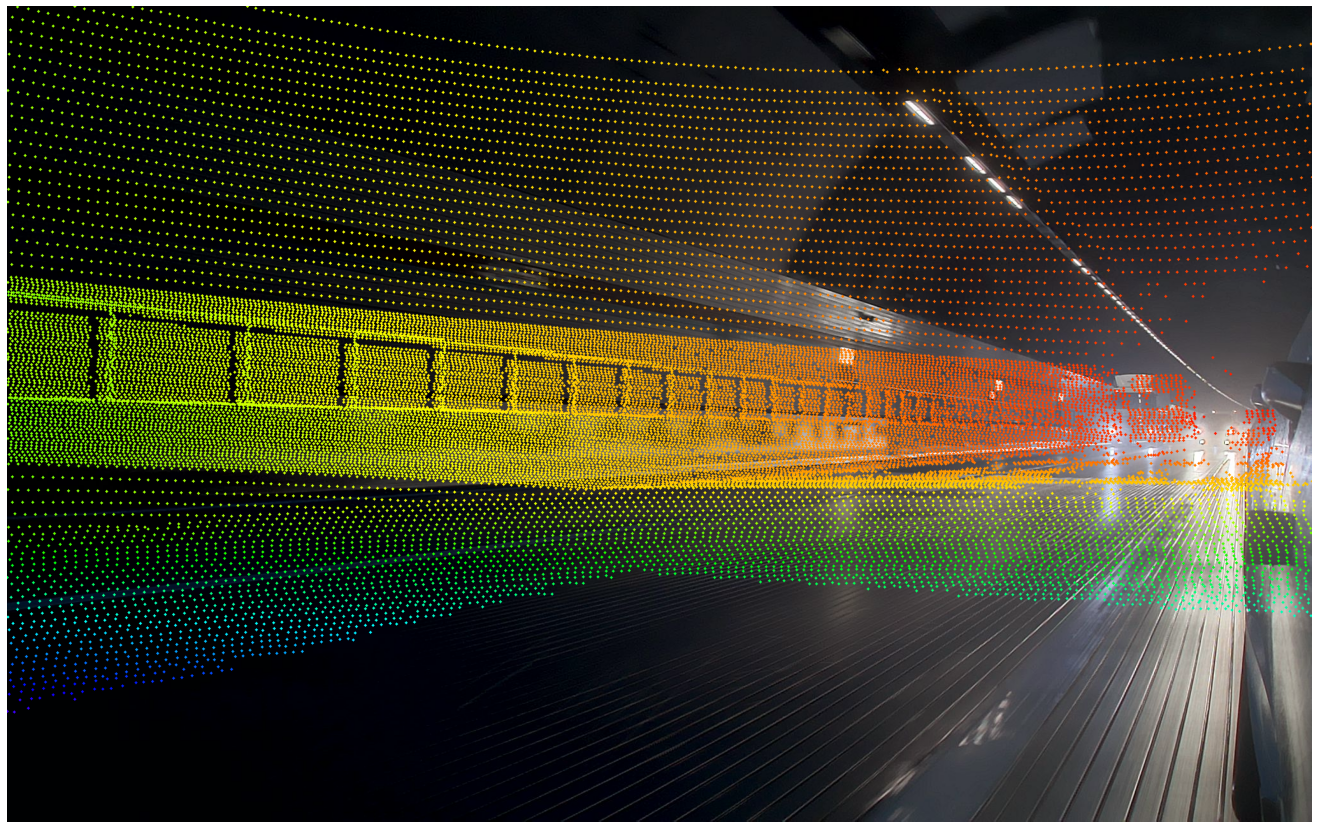

In [94]:
fig_lidar = plt.figure(figsize=(25, 15))
ax_lidar = fig_lidar.subplots()
ax_lidar.imshow(img_lidar)
plt.axis('off')
plt.show()